![image](https://docs.google.com/uc?export=download&id=1Nh6vjig-ADM1RMbaHrj_GItD3O1ZW4Vr)
# Análisis con Machine Learning - MINE4206
<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/jpcano1/MINE_4206_Analisis_con_Machine_Learning/blob/main/Lab%20V/Lab_V.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
  </td>
</table>




## Objetivos

*   Analizar conjutos de datos no estructurados
*   Aplicar diferentes técnicas de pre-procesamiento de textos.

## **Nombres de los Integrantes**
- **Integrante 1**: Diego Alejandro Peña 200814497
- **Integrante 2**: Alveiro García Niño 202022910
- **Integrante 3**: N/A



## Primer Problema
<p style="text-align: justify;"> El departamento de TI ha desarrollado un servidor de correo para brindar a todos los empleados una cuenta propia donde puedan manejar la información de la empresa. Sin embargo, debido al mal manejo de la cuenta y la falta de capacitación, los directivos se han dado cuenta que a los servidores están llegando varios mensajes <i>Spam</i> que pueden comprometer la seguridad de la información. Para eso, les han pedido construir un sistema el cual permita clasificar y descartar un mensaje <i>Spam</i> antes que llegue a los servidores. <br> Debido a que es un problema reciente y los directivos quieren actuar rápido le han brindado el siguiente archivo con los datos que lograron etiquetar, y les sugieren que utilicen los clasificadores de <i>Näive Bayes</i> y <i>Ensemblers</i>, ya que han escuchado que son muy buenos.</p>


### 1. Importando las librerias requeridas para el desarrollo del laboratorio


Para la transformación de los datos, así como para el entrenamiento de los modelos y la visualización de los resultados, se importan las siguientes librerías:


**Nota:** Para asegurarse de tener las últimas versiones y todos los paquetes instalados que por lo general no vienen en Google Colab. pueden ejecutar la sigiuente celda.

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install contractions

import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
#nltk.download()

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.12.0-py2.py3-none-any.whl size=243829 sha256=3bb9b2a5c9adf4ffb2696bfaf4eeaf27461b86c783b0fcb75027559eb89a0e41
  Stored in directory: /tmp/pip-ephem-wheel-cache-fu8onh7l/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt


### 2. Perfilamiento y entendimiento de los datos



#### Lectura de los datos
Primero, se leen los datos y se visualizan que se hayan leido correctamente.

In [ ]:
url = 'https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%204/Punto%201/SPAM%20text%20message%2020170820%20-%20Data.csv'
data = pd.read_csv(url)

train, test = train_test_split(data, test_size=0.2, random_state=33)
train.head()

,Category,Message
4183,spam,Urgent! Please call 0906346330. Your ABTA comp...
1664,ham,S but mostly not like that.
1814,ham,Yes we are chatting too.
5044,ham,O ic lol. Should play 9 doors sometime yo
4188,ham,Dear got bus directly to calicut


#### Entendimiento de los Datos

Para entender los mensajes, se realizan 'estadísticas descriptivas' para poder obtener un análisis de los textos.

In [ ]:
textos = train.copy()
textos['Conteo'] = [len(x) for x in textos['Message']]
textos['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in textos['Message']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Message']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Message']]

ProfileReport(textos)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 3. Preparación de datos

Para poder realizar el pre-procesamiento de los datos, es recomendable pasar por tres etapas:
* Eliminación del Ruido.
* Tokenización.
* Normalización.

Para mayor información, pueden consultar el [siguiente artículo](https://medium.com/datos-y-ciencia/preprocesamiento-de-datos-de-texto-un-tutorial-en-python-5db5620f1767
).

#### **3.1 Eliminación del Ruido**
La eliminación del ruido se utiliza para dejar el archivo en texto plano, sobre todo cuando vienen de diferentes fuentes como HTML, Twitter, XML, entre otros. También para eliminar caracteres especiales y pasar todo a minúscula.

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

#### **3.2 Tokenización**
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos. 

In [ ]:
train['Message'] = train['Message'].apply(contractions.fix) #Aplica la corrección de las contracciones

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train['words'] = train['Message'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Category,Message,words
4183,spam,Urgent! Please call 0906346330. Your ABTA comp...,"[urgent, please, call, nine hundred and six mi..."
1664,ham,S but mostly not like that.,"[mostly, like]"
1814,ham,Yes we are chatting too.,"[yes, chatting]"
5044,ham,of ic lol. Should play 9 doors sometime yo,"[ic, lol, play, nine, doors, sometime, yo]"
4188,ham,Dear got bus directly to calicut,"[dear, got, bus, directly, calicut]"


#### **Normalización**
Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.

In [ ]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

train['words'] = train['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Category,Message,words
4183,spam,Urgent! Please call 0906346330. Your ABTA comp...,"[urg, pleas, cal, nine hundred and six million..."
1664,ham,S but mostly not like that.,"[most, lik, mostly, like]"
1814,ham,Yes we are chatting too.,"[ye, chat, yes, chat]"
5044,ham,of ic lol. Should play 9 doors sometime yo,"[ic, lol, play, nin, door, sometim, yo, ic, lo..."
4188,ham,Dear got bus directly to calicut,"[dear, got, bus, direct, calicut, dear, get, b..."


##### **3.4 Selección de campos**

Primero, se separa la variable predictora y los textos que se van a utilizar.

In [ ]:
train['words'] = train['words'].apply(lambda x: ' '.join(map(str, x)))
train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Category,Message,words
4183,spam,Urgent! Please call 0906346330. Your ABTA comp...,urg pleas cal nine hundred and six million thr...
1664,ham,S but mostly not like that.,most lik mostly like
1814,ham,Yes we are chatting too.,ye chat yes chat
5044,ham,of ic lol. Should play 9 doors sometime yo,ic lol play nin door sometim yo ic lol play ni...
4188,ham,Dear got bus directly to calicut,dear got bus direct calicut dear get bus direc...
...,...,...,...
57,ham,"Sorry, I will call later in meeting.",sorry cal lat meet sorry call later meet
3273,ham,"MOON has come to color your dreams, STARS to m...",moon com col dream star mak mus sms giv warm p...
2706,ham,What i mean is do they come chase you out when...,mean com chas stat watch many movy want mean c...
578,ham,Ü wait 4 me in sch i finish ard 5..,u wait four sch fin ard 5 u wait four sch fini...


In [ ]:
X_train, y_train = train['words'],train['Category']
y_train = (y_train == 'spam').astype(int)
y_train

4183    1
1664    0
1814    0
5044    0
4188    0
       ..
57      0
3273    0
2706    0
578     0
2439    0
Name: Category, Length: 4457, dtype: int64

Primero, se transforma el texto con una transformación binaria 1 a 1.

In [ ]:
dummy = CountVectorizer(binary=True)
X_dummy = dummy.fit_transform(X_train)
print(X_dummy.shape)
X_dummy.toarray()[0]

(4457, 8945)


array([0, 0, 0, ..., 0, 0, 0])

También, se puede realizar el conteo de las palabras presentes.

In [ ]:
count = CountVectorizer()
X_count = count.fit_transform(X_train)
print(X_count.shape)
X_count.toarray()[0]

(4457, 8945)


array([0, 0, 0, ..., 0, 0, 0])

O, se puede realizar la transformación Term-frecuency times inverse Document-frecuency.

In [ ]:
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(X_train)
print(X_tf_idf.shape)
X_tf_idf.toarray()[0]

(4457, 8945)


array([0., 0., 0., ..., 0., 0., 0.])

### 4. Modelamiento

#### **Näive Bayes**

El algoritmo de Näive Bayes es un clasificador estadístico basado en el teorema de Bayes. 

**Dado:**

> $A: $ Eventos mutuamente exclusivos y exhaustivos (estados). <br>
$E: $ Evento observado.

El teorema establece:

$P(A_i|E) = \frac{P(E|A_i)P(A_i)}{P(E)}$

Basado en los datos que se le proporciona, estima la probabilidad que una instancia pertenezca a cada una de las clases. Y con la mayor probabilidad encontrada, asigna el valor de la clase. 

Existen tres tipos de calsificadores Bayes:

*   Bayes Ingenuo.
*   Bayes ingenuo Bernoulli (para atributos binarios).
*   Bayes ingenuo multinomial (para características discretas).

Para este caso, se utilizará el Bayes ingenuo Bernoulli.


In [ ]:
X_train = train['Message']

estimators = [('transform', CountVectorizer(stop_words='english')), 
              ('clf', BernoulliNB())]

pipe = Pipeline(estimators)

NB = pipe.fit(X_train,y_train)
NB

Pipeline(memory=None,
         steps=[('transform',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                             fit_prior=True))],
         verbose=False)

#### **Ensemblers**

* Combinan una serie de modelos para mejorar el rendimiento de
clasificación.

* Regla para combinar las predicciones de los diferentes clasificadores y producir una única salida.

* Existen diferentes modelos como Bagging, Random Forest, Adaboost, entre otros.

Para determinar el mejor modelo, se van a utilizar los tres algoritmos y se probarán con los diferentes tipos de preprocesamiento.

In [ ]:
estimators = [('transform', CountVectorizer(stop_words='english')), 
              ('clf', BaggingClassifier(base_estimator=SVC(kernel='rbf'), random_state=0))]

pipe = Pipeline(estimators)

param_grid = dict(transform =[TfidfVectorizer(stop_words='english'), 
                             CountVectorizer(stop_words='english'), 
                             HashingVectorizer(stop_words='english',
                                               n_features=2**13)],
                  clf = [RandomForestClassifier(random_state=0),
                         BaggingClassifier(base_estimator=SVC(kernel='rbf'), random_state=0),
                         AdaBoostClassifier(random_state=0)],
                  clf__n_estimators=[10,20,50],
                  )

grid_search_EN = GridSearchCV(pipe, param_grid=param_grid,verbose = 20,n_jobs=-1,error_score=0.0)
grid_search_EN.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(cv=None, error_score=0.0,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [ ]:
grid_search_EN.best_estimator_

Pipeline(memory=None,
         steps=[('transform',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_...
                                                      class_weight=None,
                                                      coef0=0.0,
                                                      decision_function_shape='ovr',
                                                      degree=3, gamma='scale',


### **5. Predicción**

In [ ]:
X_test, y_test = test['Message'],(test['Category'] == 'spam').astype(int)

#### Näive Bayes

In [ ]:
y_pred_NB = NB.predict(X_test)
y_pred_NB

array([0, 0, 0, ..., 0, 0, 0])

#### Ensemblers

In [ ]:
EN = grid_search_EN.best_estimator_
display(X_test[:2])
y_pred_EN = EN.predict(X_test)
y_pred_EN

3538    Mmmmm ... It was sooooo good to wake to your w...
4487                                 have * good weekend.
Name: Message, dtype: object

array([0, 0, 0, ..., 0, 0, 0])

### **6. Validación**

Para comparar los dos modelos, se realiza la evaluación en el conjunto de test y se construye la matriz de confusión.

In [ ]:
report_NB = classification_report(y_test, y_pred_NB,target_names=['ham','spam'])
report_EN = classification_report(y_test, y_pred_EN,target_names=['ham','spam'])

print("Test Report for Näive Bayes\n", report_NB)
print("Confusion Matrix for Näive Bayes\n", confusion_matrix(y_test, y_pred_NB))
print("Test Report for Ensemblers\n", report_EN)
print("Confusion Matrix for Ensemblers\n", confusion_matrix(y_test, y_pred_EN))

Test Report for Näive Bayes
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       962
        spam       1.00      0.84      0.91       153

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Confusion Matrix for Näive Bayes
 [[962   0]
 [ 24 129]]
Test Report for Ensemblers
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       962
        spam       1.00      0.89      0.94       153

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.97      1115
weighted avg       0.99      0.98      0.98      1115

Confusion Matrix for Ensemblers
 [[962   0]
 [ 17 136]]


Y las curvas de precisión y sensibilidad para la clase de interés

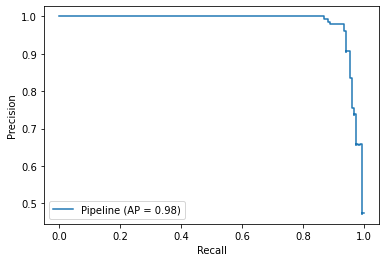

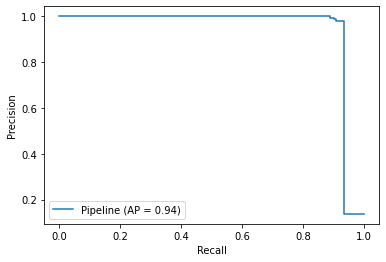

In [ ]:
plot_precision_recall_curve(NB, X_test, y_test)
plot_precision_recall_curve(EN, X_test, y_test)


# Taller



## 1. Enunciado Segundo Problema

Ante la gran demanda de noticias que se generan hoy en día, el servicio público de radio y televisión Británica BBC desea realizar un sistema que le permita clasificar diferentes noticias para mostrarlas en su página web. Para ello, le ha brindado las noticias previamente clasificadas en cinco categorías. <br>
La idea es realizar un clasificador Näive Bayes para la realización de este problema.

In [ ]:
import requests
f = requests.get("https://raw.githubusercontent.com/jcestevezc/Machine-Learning-Techniques/master/Laboratorio%204/Punto%202/README.TXT")
print(f.text)

Consists of 2225 documents from the BBC news website corresponding to stories in five topical areas from 2004-2005.
Natural Classes: 5 (business, entertainment, politics, sport, tech)

If you make use of the dataset, please consider citing the publication: 
- D. Greene and P. Cunningham. "Practical Solutions to the Problem of Diagonal Dominance in Kernel Document Clustering", Proc. ICML 2006.

All rights, including copyright, in the content of the original articles are owned by the BBC.

Contact Derek Greene <derek.greene@ucd.ie> for further information.
http://mlg.ucd.ie/datasets/bbc.html




## 2. Perfilamiento y entendimiento de los datos

Se observa que los datos proporcionados están clasificados en 5 carpetas diferentes, las cuales corresponden a las 5 categorías mencionadas en el enunciado del problema. Las categorías de los textos son:

*   Negocios (Business)
*   Entretenimiento (Entertainment)
*   Política (Politics)
*   Deproted (Sport)
*   Tecnología (Tech)

Dado que los documentos proporcionados están divididos por categoría y cada categoría contiene muchos documentos, es necesario generar un solo dataset que contennga todos los datos y crear un atributo que será la categoría a la  que corresponden.



El siguiente código fue creado y ejecutado localmente para generar el dataset completo. El carácter separador definido es "¬" para no tener inconveniente con los carácteres definidos en el texto.

In [ ]:
import os

# Getting current directory
CURR_DIR = os.getcwd()

totalData = open("TotalData.csv","w")
totalData.write("Category¬Message\n")

# Listing all files and folder in the path
filesAndFolders = os.listdir(CURR_DIR)
# Removing undesired files
i = 0
toRemove = []
# Get all folders where the text files are located
for current in filesAndFolders:
	extension = current.split(".")
	# Removing python files and text files
	print(extension[-1].lower())
	if((extension[-1].lower() == "py") or (extension[-1].lower() == "txt") or (extension[-1].lower() == "csv")):
		toRemove.append(i)
	i = i + 1

# Reversing list to pop objects
toRemove.reverse()
# Removing objects from list
for current in toRemove:
	filesAndFolders.pop(current)

# Iterating each folder to get all files
for folder in filesAndFolders:
	newPath = CURR_DIR + "\\" + folder
	print(folder)
	files = os.listdir(newPath)
	# Iterating list of files
	for file in files:
		readInfo = ""
		# Opening each file to extract the info
		with open(newPath + "\\" + file) as textFile:
			# Reading each line of the file
			for row in textFile:
				# Checking if the line has a end of line character
				lastChar = row[-1]
				if(lastChar == '\n'):
					newRow = row[:-1]
				else:
					newRow = row
				# Storing all the file data in one string
				readInfo = readInfo + newRow + " "
		
		# Writing all the data in the CSV file
		totalData.write(folder + "¬" + readInfo + "\n")
		print(file)

# Closing the all data file
totalData.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Los datos se leen usando el encoding "iso-8859-1" para no perder información de los textos. Asimismo, se especifica el carácter "¬" usado como separador de los datos.

In [ ]:
data = pd.read_csv(r'/content/drive/My Drive/Datasets/TotalData.csv', sep='¬', header=0, encoding='iso-8859-1' ,error_bad_lines = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
data.head()

,Category,Message
0,business,Ad sales boost Time Warner profit Quarterly p...
1,business,Dollar gains on Greenspan speech The dollar h...
2,business,Yukos unit buyer faces loan claim The owners ...
3,business,High fuel prices hit BA's profits British Air...
4,business,Pernod takeover talk lifts Domecq Shares in U...


In [ ]:
# Checking the message length
len(data['Message'].loc[4])

1570

In [ ]:
# Checking the message is complete
data['Message'].loc[4]

"Pernod takeover talk lifts Domecq  Shares in UK drinks and food firm Allied Domecq have risen on speculation that it could be the target of a takeover by France's Pernod Ricard.  Reports in the Wall Street Journal and the Financial Times suggested that the French spirits firm is considering a bid, but has yet to contact its target. Allied Domecq shares in London rose 4% by 1200 GMT, while Pernod shares in Paris slipped 1.2%. Pernod said it was seeking acquisitions but refused to comment on specifics.  Pernod's last major purchase was a third of US giant Seagram in 2000, the move which propelled it into the global top three of drinks firms. The other two-thirds of Seagram was bought by market leader Diageo. In terms of market value, Pernod - at 7.5bn euros ($9.7bn) - is about 9% smaller than Allied Domecq, which has a capitalisation of Â£5.7bn ($10.7bn; 8.2bn euros). Last year Pernod tried to buy Glenmorangie, one of Scotland's premier whisky firms, but lost out to luxury goods firm LV

### Separación de datos

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=33)
train.head()

,Category,Message
842,entertainment,Actor Scott is new Bond favourite Bookmaker W...
886,entertainment,UK Directors Guild nominees named Martin Scor...
220,business,BP surges ahead on high oil price Oil giant B...
328,business,House prices drop as sales slow House prices ...
721,entertainment,Little Britain two top comic list Little Brit...


### Perfilamiento de datos

In [ ]:
textos = train.copy()
textos['Conteo'] = [len(x) for x in textos['Message']]
textos['Moda'] = [max(set(x.split(' ')), key = x.split(' ').count) for x in textos['Message']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Message']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Message']]

ProfileReport(textos)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Preparación de datos

De acuerdo a las bases explicadas durante el desarrollo del ejemplo del taller, decimos que es recomendable pasar por las siguientes tres etapas para realizar el pre-procesamiento de los datos:

* Eliminación del Ruido.
* Tokenización.
* Normalización.

### 3.1 Eliminación del Ruido
La eliminación del ruido para dejar el archivo en texto plano. En este caso se realiza especialmente para eliminar caracteres especiales y pasar todo a minúscula.

In [ ]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### 3.2 Tokenización
La tokenización permite dividir frases u oraciones en palabras. Con el fin de desglozar las palabras correctamente para el posterior análisis. Pero primero, se realiza una corrección de las contracciones que pueden estar presentes en los textos.

In [ ]:
train['Message'] = train['Message'].apply(contractions.fix) #Aplica la corrección de las contracciones

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train['words'] = train['Message'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Category,Message,words
842,entertainment,Actor Scott is new Bond favourite Bookmaker W...,"[actor, scott, new, bond, favourite, bookmaker..."
886,entertainment,UK Directors Guild nominees named Martin Scor...,"[uk, directors, guild, nominees, named, martin..."
220,business,BP surges ahead on high oil price Oil giant B...,"[bp, surges, ahead, high, oil, price, oil, gia..."
328,business,House prices drop as sales slow House prices ...,"[house, prices, drop, sales, slow, house, pric..."
721,entertainment,Little Britain two top comic list Little Brit...,"[little, britain, two, top, comic, list, littl..."


### 3.3 Normalización
Para la normalización de los datos se realiza una eliminación de prefijos y sufijos, además de realizar una lemmatización de los verbos.


In [ ]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

In [ ]:
train['words'] = train['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Category,Message,words
842,entertainment,Actor Scott is new Bond favourite Bookmaker W...,"[act, scot, new, bond, favourit, bookmak, will..."
886,entertainment,UK Directors Guild nominees named Martin Scor...,"[uk, direct, guild, nomin, nam, martin, scorse..."
220,business,BP surges ahead on high oil price Oil giant B...,"[bp, surg, ahead, high, oil, pric, oil, giant,..."
328,business,House prices drop as sales slow House prices ...,"[hous, pric, drop, sal, slow, hous, pric, fel,..."
721,entertainment,Little Britain two top comic list Little Brit...,"[littl, britain, two, top, com, list, littl, b..."


### 3.4 Selección de campos
Primero, se separa la variable predictora y los textos que se van a utilizar.

In [ ]:
train['words'] = train['words'].apply(lambda x: ' '.join(map(str, x)))
train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Category,Message,words
842,entertainment,Actor Scott is new Bond favourite Bookmaker W...,act scot new bond favourit bookmak william hil...
886,entertainment,UK Directors Guild nominees named Martin Scor...,uk direct guild nomin nam martin scorses clint...
220,business,BP surges ahead on high oil price Oil giant B...,bp surg ahead high oil pric oil giant bp annou...
328,business,House prices drop as sales slow House prices ...,hous pric drop sal slow hous pric fel novemb p...
721,entertainment,Little Britain two top comic list Little Brit...,littl britain two top com list littl britain s...
...,...,...,...
2109,tech,Peer-to-peer nets 'here to stay' Peer-to-peer...,peertop net stay peertop p2p network stay verg...
102,business,"US insurer Marsh cuts 2,500 jobs Up to 2,500 ...",us ins marsh cut 2500 job 2500 job go us ins b...
57,business,Electrolux to export Europe jobs Electrolux s...,electrolux export europ job electrolux saw sha...
578,entertainment,Foxx and Swank take actors awards Jamie Foxx ...,foxx swank tak act award jamy foxx hil swank s...


In [ ]:
from sklearn.preprocessing import LabelEncoder
X_train, y_train = train['words'],train['Category']
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

print(le.classes_)
y_train

['business' 'entertainment' 'politics' 'sport' 'tech']


array([1, 1, 0, ..., 0, 1, 3])

A continuación podemos tener una noción de como se distribuyen las palabras en el vector

In [ ]:
dummy = CountVectorizer(binary=True, stop_words='english')
X_dummy = dummy.fit_transform(X_train)
print(X_dummy.shape)
print(X_dummy.toarray()[0])
count_vect_df = pd.DataFrame(X_dummy.todense(), columns=dummy.get_feature_names())
count_vect_df.head()

(1780, 33274)
[0 0 0 ... 0 0 0]


,00,00051,001,002,003,01,019secs,02,022,024,025,027,03,030,0305,04,040,05,0530gmt,06,0605,067,07,0708,08,089,09,090,098,099,10,1000,10000,100000,1000000000,10000m,10000vote,1000bn,1000m,1000s,...,zid,zidane,zier,ziers,zil,zillion,zimbabw,zimbabwe,zinc,zint,zip,ziy,ziyi,zodiac,zoe,zol,zola,zomb,zomba,zombic,zombie,zombies,zombiesleapingoutofshadow,zombiesleapingoutofshadows,zomby,zon,zone,zoom,zornotz,zornotza,zorro,zubair,zuluag,zuluaga,zurich,zuton,zutons,zvonarev,zvonareva,zvyagintsev
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


El hashVectorizer nos entrega una serie de pesos. En este caso usamos hasta 100 features debido a que se sobrepasa la memoria 

In [ ]:
hv = HashingVectorizer(stop_words='english', n_features=100)
X_hash = hv.fit_transform(X_train)
print(X_hash.shape)
print(X_hash.toarray()[0])


(1780, 100)
[-0.10593368  0.07062246 -0.07062246  0.07062246 -0.03531123 -0.03531123
  0.         -0.03531123  0.03531123  0.24717859  0.          0.03531123
  0.03531123 -0.10593368  0.03531123  0.03531123  0.10593368 -0.21186737
  0.17655614 -0.03531123 -0.03531123 -0.24717859 -0.07062246  0.07062246
 -0.03531123 -0.24717859  0.03531123  0.          0.         -0.03531123
  0.         -0.03531123  0.14124491 -0.10593368  0.14124491  0.07062246
 -0.03531123  0.03531123  0.03531123 -0.10593368 -0.07062246 -0.35311228
  0.          0.07062246  0.         -0.14124491  0.07062246  0.14124491
  0.          0.07062246  0.          0.         -0.17655614  0.03531123
  0.17655614 -0.28248982  0.         -0.10593368  0.03531123  0.
 -0.14124491  0.03531123  0.21186737  0.03531123 -0.10593368  0.07062246
  0.03531123  0.         -0.07062246  0.         -0.03531123 -0.03531123
  0.07062246 -0.03531123 -0.03531123  0.          0.07062246  0.
 -0.03531123  0.         -0.03531123  0.14124491  0.035

Para TF IDF tambien y se visualiza la estructura de vectores generada. 

In [ ]:
tf_idf = TfidfVectorizer()
X_tf_idf = tf_idf.fit_transform(X_train)
print(X_tf_idf.shape)
print(X_tf_idf.toarray()[0])
tf_idf_df = pd.DataFrame(X_tf_idf.toarray(), columns=tf_idf.get_feature_names())
tf_idf_df.head()

(1780, 33487)
[0. 0. 0. ... 0. 0. 0.]


,00,00051,001,002,003,01,019secs,02,022,024,025,027,03,030,0305,04,040,05,0530gmt,06,0605,067,07,0708,08,089,09,090,098,099,10,1000,10000,100000,1000000000,10000m,10000vote,1000bn,1000m,1000s,...,zid,zidane,zier,ziers,zil,zillion,zimbabw,zimbabwe,zinc,zint,zip,ziy,ziyi,zodiac,zoe,zol,zola,zomb,zomba,zombic,zombie,zombies,zombiesleapingoutofshadow,zombiesleapingoutofshadows,zomby,zon,zone,zoom,zornotz,zornotza,zorro,zubair,zuluag,zuluaga,zurich,zuton,zutons,zvonarev,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4. Modelamiento
De acuerdo a las especificaciones para el desarrollo de este taller se utilizará el algoritmo Näive Bayes. Dado que se clasifican varias clases, y por tanto el problema no es binario, se decide usar la librería de MultinomialNB

In [ ]:
estimators = [('transform', CountVectorizer(stop_words='english')), 
              ('clf', MultinomialNB())]

pipe = Pipeline(estimators)

NB = pipe.fit(X_train,y_train)
NB

Pipeline(memory=None,
         steps=[('transform',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

Hacemos uso de GridSearch para obtener el mejor parametro a partir de los vectores que vimos anteriormente 

In [ ]:
param_grid = dict(transform =[TfidfVectorizer(stop_words='english'), 
                             CountVectorizer(stop_words='english'), 
                             HashingVectorizer(stop_words='english',
                                               n_features=2**13)],
                  clf__alpha=[1,5,10]#,
                  #clf__class_prior=[True, False]
                  )

grid_search_EN = GridSearchCV(pipe, param_grid=param_grid,verbose = 20,n_jobs=-1,error_score=0.0)
grid_search_EN.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:   

GridSearchCV(cv=None, error_score=0.0,
             estimator=Pipeline(memory=None,
                                steps=[('transform',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [ ]:
grid_search_EN.best_estimator_

Pipeline(memory=None,
         steps=[('transform',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1, class_prior=None, fit_prior=True))],
         verbose=False)

## 5. Predicción

In [ ]:
X_test = test['Message']
y_test = test['Category']
le.fit(y_test)
y_test = le.transform(y_test)

In [ ]:
y_pred_NB = NB.predict(X_test)
y_pred_NB

array([0, 3, 0, 1, 3, 3, 4, 0, 3, 3, 2, 0, 4, 4, 1, 1, 1, 1, 0, 3, 4, 4,
       3, 2, 0, 1, 3, 3, 1, 4, 0, 0, 2, 4, 0, 2, 2, 4, 3, 1, 1, 4, 2, 0,
       3, 1, 0, 4, 4, 2, 0, 2, 1, 4, 0, 3, 4, 1, 0, 3, 1, 3, 4, 2, 3, 3,
       2, 1, 1, 0, 0, 1, 1, 2, 0, 4, 0, 4, 1, 0, 1, 2, 2, 1, 1, 3, 4, 4,
       3, 0, 4, 3, 0, 1, 0, 3, 0, 4, 0, 4, 1, 1, 0, 4, 2, 4, 3, 1, 0, 0,
       4, 3, 3, 4, 4, 3, 3, 2, 3, 0, 1, 3, 0, 2, 3, 0, 1, 2, 4, 3, 3, 4,
       3, 1, 0, 4, 2, 0, 0, 0, 4, 2, 0, 1, 2, 1, 2, 0, 0, 0, 3, 0, 2, 3,
       0, 0, 3, 2, 4, 1, 3, 3, 0, 2, 2, 2, 0, 4, 4, 3, 0, 0, 4, 3, 0, 0,
       0, 0, 4, 3, 4, 3, 4, 3, 0, 1, 4, 1, 2, 3, 1, 1, 3, 1, 3, 4, 4, 4,
       3, 2, 2, 4, 0, 0, 1, 0, 0, 4, 2, 2, 1, 1, 0, 4, 2, 1, 1, 0, 1, 2,
       3, 0, 4, 0, 1, 2, 0, 0, 1, 1, 1, 4, 0, 4, 3, 3, 0, 3, 1, 0, 0, 0,
       0, 4, 4, 3, 3, 1, 2, 4, 3, 3, 3, 4, 0, 3, 0, 3, 0, 0, 3, 1, 4, 2,
       3, 2, 1, 3, 4, 4, 4, 2, 2, 1, 0, 4, 0, 4, 3, 3, 0, 4, 2, 3, 3, 4,
       0, 1, 2, 0, 3, 1, 2, 0, 3, 1, 2, 1, 4, 2, 2,

## 6. Validación

In [ ]:
report_NB = classification_report(y_test, y_pred_NB,target_names=['businness','entertainment','politics','sport','tech'])

print("Test Report for Näive Bayes\n", report_NB)
print("Confusion Matrix for Näive Bayes\n", confusion_matrix(y_test, y_pred_NB))

Test Report for Näive Bayes
                precision    recall  f1-score   support

    businness       0.96      0.98      0.97       109
entertainment       0.99      0.96      0.98        83
     politics       0.96      0.99      0.97        70
        sport       1.00      0.97      0.98        98
         tech       0.99      0.99      0.99        85

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445

Confusion Matrix for Näive Bayes
 [[107   1   1   0   0]
 [  1  80   1   0   1]
 [  1   0  69   0   0]
 [  2   0   1  95   0]
 [  1   0   0   0  84]]


Curva de precisión y sensibilidad para las clases de interés

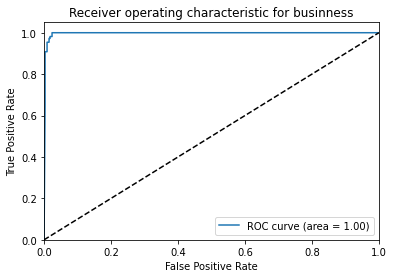

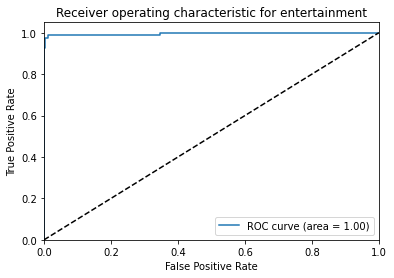

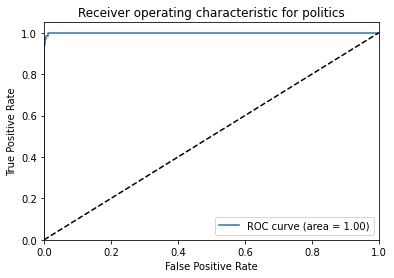

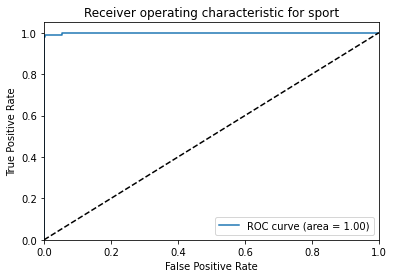

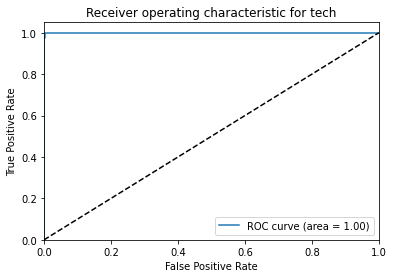

In [ ]:


clf = OneVsRestClassifier(Pipeline(estimators))
y_score = clf.fit(X_train, y_train).predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])

target_classes = ['businness','entertainment','politics','sport','tech']

n_classes = 5


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for ' + target_classes[i])
    plt.legend(loc="lower right")
    plt.show()

Se observa que se tienen unos performances bastante buenos para cada una de las clases. Es probable que este resultado se este dando porque los lenguajes usados para cada tipo de noticias son bastante especificos y de esa forma el clasificador puede hacer el analisis de forma mas adecuada. Adicionalmente el hecho de remover las stop words aporta para que el clasficador pueda hacer la tarea de mejor forma 